# 04 - Model building

### Import packages

In [196]:
# Import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Set base directory 
base_dir = Path(os.getcwd()).parent

# Set default figure directory
fig_dir = base_dir / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Set matplotlib backend to PDF-friendly (optional, for consistent rendering)
plt.rcParams["pdf.fonttype"] = 42  # Ensures text is saved as text (not paths)
plt.rcParams["ps.fonttype"] = 42

### Load data

In [ ]:
# Load the dataset
data_dir = base_dir / "data" 
data_file = data_dir / "processed" / "HR_capstone_dataset_no_outliers.csv"

# Read the cleaned CSV file into a pandas DataFrame
df_cleaned = pd.read_csv(data_file)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


💭 Constructing Stage Reflection

**Do you notice anything odd?**
-   The dataset exhibits significant class imbalance with far more employees staying than leaving, which necessitated upsampling to create a balanced training set. Additionally, there's notable multicollinearity between last_evaluation, number_of_projects, and average_monthly_hours, suggesting these variables are interconnected as expected in workplace dynamics.

**Which independent variables did you choose for the model and why?**
-  All available features were included after preprocessing: satisfaction level, last evaluation, number of projects, average monthly hours, tenure, work accidents, promotions, salary levels, and departments. This comprehensive approach allows the model to capture the full spectrum of factors influencing employee turnover, with categorical variables converted to dummy variables using one-hot encoding.

**Are each of the assumptions met?**
- ✅ Outcome variable is categorical: Binary outcome (Left=1, Stayed=0)
- ⚠️ Independence of observations: While generally true, there may be some dependency as employees might leave in waves or influence each other's decisions
- ⚠️ No perfect multicollinearity: Some correlation exists between evaluation scores, project count, and hours worked, which is logically expected but could affect coefficient interpretation
- ✅ Linear relationship: Between log-odds and predictors (addressed through proper scaling and encoding)

**Ethical considerations**:
- Privacy: Ensure employee data is anonymized and used only for organizational improvement


## Step 3. Model Building, Step 4. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

We aim to predict whether an employee will leave or stay at the company. This is a **supervised machine learning task**, because:

- We have labeled data (employees who stayed or left),
- And we want to learn a model from that data to predict future outcomes.

Since the outcome variable has only two possible values (e.g., *leave* vs. *stay*, or *1* vs. *0*), this is specifically a:

- **Binary classification task**


### Identify the types of models most appropriate for this task.

Common algorithms for binary classification include:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- Gradient Boosted Trees (e.g., XGBoost, LightGBM)
- Neural Networks (for more complex data)



### Modeling

#### Preprocessing

This step prepares a balanced dataset for logistic regression modeling by addressing the class imbalance problem in the employee turnover data. It separates employees who left from those who stayed, then uses upsampling (sampling with replacement) to increase the minority class (employees who left) to match the size of the majority class (employees who stayed), creating a balanced dataset that prevents the model from being biased toward predicting the majority class.

In [220]:
# We will employ the explanatory power of logistic regression
# To test the model, we will split the data into training and testing sets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.utils import resample

# Define the target variable
target_var = 'has_left_company'
y = df0[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary

# Given that we observe a heavily imbalanced dataset and not too many observations,
# we will employ upsampling to ensure that both classes are represented in the training and testing sets

# Separate majority and minority classes
df_majority = df0[df0[target_var] == 'Stayed']
df_minority = df0[df0[target_var] == 'Left']

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),  # Match number in majority class
                                 random_state=42)  # Reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the upsampled DataFrame
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_94631/1513575396.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df0[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary


#### One-hot encode categorical variables

This step prepares the upsampled dataset for machine learning by separating features from the target variable and converting the target to binary format (1 for 'Left', 0 for 'Stayed'). It also applies one-hot encoding to categorical variables and ensures all features are in float format for consistent processing by machine learning algorithms.

In [221]:
X_upsampled = df_upsampled.drop(columns=[target_var])
y_upsampled = df_upsampled[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary

X_upsampled = pd.get_dummies(X_upsampled, drop_first=True)
X_upsampled = X_upsampled.astype(float)

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_94631/1845552619.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_upsampled = df_upsampled[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary


#### Normalizing the data without leakage

This step splits the preprocessed data into training and testing sets (80/20 split) while maintaining the same proportion of target classes in both sets through stratification. It then applies Min-Max scaling to normalize all features to a 0-1 range, fitting the scaler only on training data and applying the same transformation to test data to prevent data leakage.

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split first
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, stratify=y_upsampled, random_state=42)

# Then fit scaler on training data only
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Use the same scaler to transform test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#### Model fitting

This step creates and trains a logistic regression model using statsmodels by adding a constant term (intercept) to the scaled training features and fitting the model to predict employee turnover. The model summary is then printed to display detailed statistical results including coefficients, p-values, and model performance metrics.

In [240]:
# Define the model
X_train_scaled = sm.add_constant(X_train_scaled)  # Adds a constant term to the predictor
model = sm.Logit(y_train.values, X_train_scaled)

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.518240
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                18284
Model:                          Logit   Df Residuals:                    18265
Method:                           MLE   Df Model:                           18
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                  0.2523
Time:                        21:04:58   Log-Likelihood:                -9475.5
converged:                       True   LL-Null:                       -12674.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.1961      0.136    -16.102     

#### Model evaluation

This step evaluates the trained logistic regression model by making predictions on the hold out test set. For evaulation we generate a classification report, AUC-ROC plot & confusion matrix

In [241]:
# Evaluate the model's performance
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
X_test_scaled = sm.add_constant(X_test_scaled)  # Adds a constant term to the predictor
y_pred = result.predict(X_test_scaled)

# Classification report
class_report = classification_report(y_test, (y_pred > 0.5).astype(int))
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2286
           1       0.76      0.80      0.78      2286

    accuracy                           0.78      4572
   macro avg       0.78      0.78      0.78      4572
weighted avg       0.78      0.78      0.78      4572



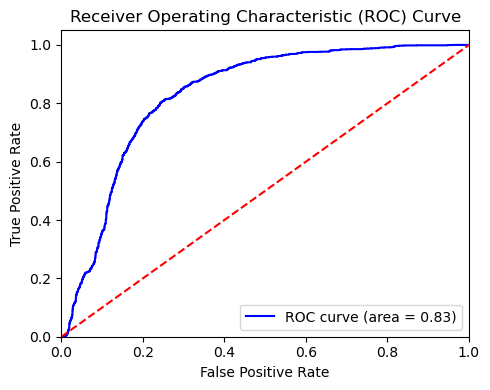

In [242]:
# Plot the AUROC-ROC curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) 
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(fig_dir / 'roc_curve.pdf')
plt.show()

Confusion Matrix:
[[1721  565]
 [ 447 1839]]


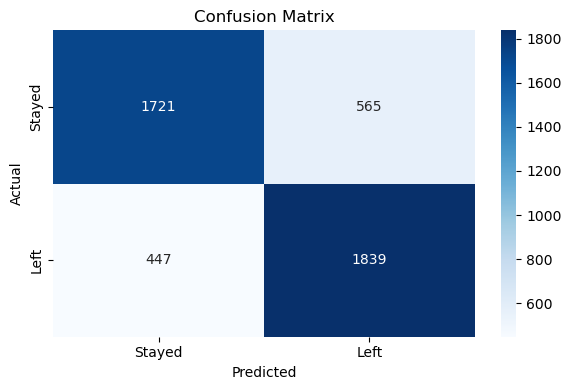

In [243]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(fig_dir / 'confusion_matrix.pdf')
plt.show()

#### Plot odds ratios of the logistic regression model

This step extracts the logistic regression coefficients and converts them to odds ratios with 90% confidence intervals to interpret the model results. It creates a horizontal error bar plot on a log scale showing how each feature affects the odds of employee turnover, with a reference line at odds ratio = 1 indicating no effect, making it easy to identify which factors increase or decrease the likelihood of employees leaving.

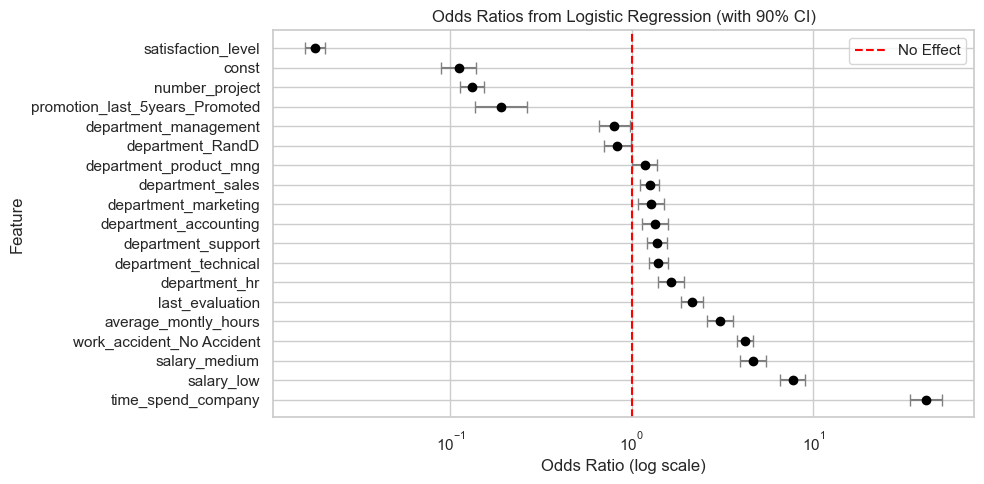

In [293]:
# Obtain the coefficients of the logistic regression model

# Get the 90% confidence interval of the *log* coefficients
conf = result.conf_int(alpha=0.10)  # 90% CI → 5% and 95%
conf.columns = ['5%', '95%']

# Add the point estimate (coefficient)
conf['Coefficient'] = result.params

# Exponentiate coefficients and CI bounds
conf['Odds Ratio'] = np.exp(conf['Coefficient'])
conf['5%'] = np.exp(conf['5%'])
conf['95%'] = np.exp(conf['95%'])

# Create figure for plotting
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

# Reset index for plotting
df = conf.reset_index().rename(columns={'index': 'Feature'})
# Sort by Odds Ratio for better visualization
df = df.sort_values(by='Odds Ratio', ascending=False)

# Plot horizontal error bars
plt.errorbar(
    x=df['Odds Ratio'],
    y=df['Feature'],
    xerr=[df['Odds Ratio'] - df['5%'], df['95%'] - df['Odds Ratio']],
    fmt='o',
    color='black',
    ecolor='gray',
    capsize=4
)

# Log scale for better visual balance
plt.xscale('log')

# Reference line at OR = 1 (no effect)
plt.axvline(x=1, color='red', linestyle='--', label='No Effect')

plt.xlabel('Odds Ratio (log scale)')
plt.ylabel('Feature')
plt.title('Odds Ratios from Logistic Regression (with 90% CI)')
plt.tight_layout()
plt.legend()
plt.savefig(fig_dir / 'odds_ratio_with_ci_logscale.pdf')
plt.show()

### Insights After Model Construction

- The logistic regression model demonstrates strong predictive performance with an AUC of 0.83, indicating good overall discriminative ability.
- Even for the minority class (employees who left), the model achieves a recall of 0.8, capturing most actual leavers.
- Several factors were identified as key drivers of employee turnover:
    - Low salary significantly increases the likelihood of leaving.
    - Longer tenure is associated with higher odds of departure.
    - Higher job satisfaction reduces the likelihood of leaving.
    - Greater project involvement is linked to employee retention.
    - Recent promotions are associated with lower turnover rates.

# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders



✏
## Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






💭
### Reflect on these questions as you complete the executing stage.

- What key insights emerged from your model(s)?
- What business recommendations do you propose based on the models built?
- What potential recommendations would you make to your manager/company?
- Do you think your model could be improved? Why or why not? How?
- Given what you know about the data and the models you were using, what other questions could you address for the team?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?



Double-click to enter your responses here.

## Step 4. Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




### Summary of model results

[Double-click to enter your summary here.]

### Conclusion, Recommendations, Next Steps

[Double-click to enter your conclusion, recommendations, and next steps here.]